In [26]:
# installing 1.0.3 because this version of pandas supports write to s3
!pip install pandas

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Upgrades

In [27]:
# This path will be active after the launch of the hackathon
teamname = '9417-brhuang-unsw'
data_folder='s3://tf-trachack-data/212/'
# change root_folder to your team's root folder
# s3://tf-trachack-notebooks/<this should be replaced by team name as provided in EMAIL>/jupyter/jovyan/
root_folder='s3://tf-trachack-notebooks/'+'9417-brhuang-unsw'+'/jupyter/jovyan/'

In [28]:
import pandas as pd
upgrades=pd.read_csv(data_folder+"data/dev/upgrades.csv")
upgrades.head(2)

,line_id,date_observed,upgrade
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,yes
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,yes


In [29]:
len(upgrades)

55868

The goal of the challenge is to predict upgrade. These examples have labels from historical data.

In [30]:
upgrades['upgrade'].value_counts()

no     40694
yes    15174
Name: upgrade, dtype: int64

## LRP Points

In [31]:
lrp_points=pd.read_csv(data_folder+"data/dev/lrp_points.csv")
lrp_points.head(2)

,line_id,quantity,status,total_quantity,update_date
0,77f81f11-ed62-438d-9c04-02e3bcc0d756,2180.0,ENROLLED,2180.0,2021-01-02
1,d664604d-8b68-4302-b599-0165df0f27ad,1210.0,ENROLLED,1210.0,2021-01-03


In [32]:
len(lrp_points)

8860

## LRP Enrollment

In [33]:
lrp_enrollment=pd.read_csv(data_folder+"data/dev/lrp_enrollment.csv")
lrp_enrollment.head(2)

,line_id,lrp_enrolled,lrp_enrollment_date
0,487ddc53-0fe4-429e-950d-8f3de2231883,Y,2019-12-02
1,081267e8-6fd7-467e-96e2-758cd8597800,Y,2017-04-30


In [34]:
len(lrp_enrollment)

17634

# ________________________my code______________________________________

In [35]:
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [36]:
def CreateVariableSummary(df, save=None):
    """
    Input: 
      df = data frame to summarise
      save = string name of dataframe you wish to save
    Returns:
      A dataframe that breaks down all variables in a dataframe by unique, missing, datatype, and frequency,
      Option to save the file
    """
    result = pd.DataFrame({
        'Col':          df.columns,
        'Unique':       [df[col].nunique() for col in df.columns],
        'Missing':      [len(df[col]) - df[col].count() for col in df.columns],
        'Datatype':     list(df.dtypes),
        'Most Freq':    [list(df[col].value_counts().index[:5]) for col in df.columns],
        'Least Freq':   [list(df[col].value_counts().index[-5:]) for col in df.columns]})
    
    if save != None:
        result.to_excel(f"{WRKDIR}/Data/new/'VariableSummary{save}.xls", index = False)

    return result

In [37]:
lrp_points

,line_id,quantity,status,total_quantity,update_date
0,77f81f11-ed62-438d-9c04-02e3bcc0d756,2180.0,ENROLLED,2180.0,2021-01-02
1,d664604d-8b68-4302-b599-0165df0f27ad,1210.0,ENROLLED,1210.0,2021-01-03
2,9391d70b-14b4-41a6-ab94-130a333a9dc6,258.0,ENROLLED,258.0,2021-01-01
3,d0d9dd33-735d-48cb-b86b-39be4cb9af87,250.0,ENROLLED,250.0,2021-01-23
4,e0be071e-fe84-49a8-9622-cc43aa10fba1,320.0,ENROLLED,320.0,2021-02-21
...,...,...,...,...,...
8855,0dab0da2-cf10-430b-8d39-6ae20b29d3c3,466.0,ENROLLED,466.0,2021-02-23
8856,820bfca5-1f48-48ca-98b9-654e7271c72c,691.0,ENROLLED,691.0,2021-03-04
8857,90feb6e8-98f5-4f70-991d-b25143cb207a,1700.0,ENROLLED,1700.0,2020-12-30
8858,d001eeb6-40e9-48a2-b56d-03ec1ef57c5f,750.0,ENROLLED,750.0,2021-03-01


### Checking for missing values in lrp_points

In [38]:
CreateVariableSummary(lrp_points)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,8860,0,object,"[86e26362-3cbd-42d7-b69c-c24d2f9edea0, a949d69...","[ed4caa75-3af6-4e18-bcf8-b3468ab7ace3, 56850d4..."
1,quantity,2228,1,float64,"[240.0, 280.0, 250.0, 320.0, 258.0]","[4910.0, 3490.0, 3082.0, 1944.0, 2864.0]"
2,status,1,0,object,[ENROLLED],[ENROLLED]
3,total_quantity,2285,1,float64,"[240.0, 280.0, 250.0, 320.0, 258.0]","[2032.0, 2233.0, 9039.0, 4108.0, 576.0]"
4,update_date,126,0,object,"[2021-02-24, 2021-02-23, 2021-02-25, 2021-02-2...","[2020-11-26, 2020-12-07, 2020-11-21, 2020-12-1..."


In [39]:
lrp_points[lrp_points['quantity']==0.0]

,line_id,quantity,status,total_quantity,update_date


In [40]:
lrp_points[lrp_points['total_quantity']==0.0]

,line_id,quantity,status,total_quantity,update_date


###### I have a feeling that the NaN means the person had no points or recieved no points
###### therefore, I replaced the NaN with 0s

In [41]:
lrp_points[pd.isna(lrp_points['quantity'])]

,line_id,quantity,status,total_quantity,update_date
1029,6b14e3db-483f-44ea-ab28-80f1473576c4,NaN,ENROLLED,NaN,2021-01-25


### replacing missing values in lrp_points with 0

In [42]:
lrpp = lrp_points.copy()
lrpp['quantity'].replace({np.NaN: 0}, inplace=True)
lrpp['total_quantity'].replace({np.NaN: 0}, inplace=True)
CreateVariableSummary(lrpp)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,8860,0,object,"[86e26362-3cbd-42d7-b69c-c24d2f9edea0, a949d69...","[ed4caa75-3af6-4e18-bcf8-b3468ab7ace3, 56850d4..."
1,quantity,2229,0,float64,"[240.0, 280.0, 250.0, 320.0, 258.0]","[2722.0, 2943.0, 4250.0, 2636.0, 576.0]"
2,status,1,0,object,[ENROLLED],[ENROLLED]
3,total_quantity,2286,0,float64,"[240.0, 280.0, 250.0, 320.0, 258.0]","[2233.0, 9039.0, 4108.0, 1871.0, 576.0]"
4,update_date,126,0,object,"[2021-02-24, 2021-02-23, 2021-02-25, 2021-02-2...","[2020-11-26, 2020-12-07, 2020-11-21, 2020-12-1..."


### checking for missing values in lrp_enrollment

In [43]:
CreateVariableSummary(lrp_enrollment)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,17626,0,object,"[a7815c1c-d5d4-4078-8418-c1317462fd19, f3afc43...","[5d0a9dab-ab09-446c-889f-61a08c41f10f, de04691..."
1,lrp_enrolled,1,0,object,[Y],[Y]
2,lrp_enrollment_date,1654,0,object,"[2021-02-23, 2020-12-23, 2021-02-24, 2020-10-2...","[2017-05-31, 2017-03-15, 2017-09-29, 2018-11-0..."


In [44]:
print(lrpp.shape[0])
print(lrp_enrollment.shape[0])

8860
17634


#### notes on joining lrp points and lrp_enrollment
there are more rows in lrp_enrollments than lrp_points. This means that lrp_points do not include everyone that is enrolled. It can possibly mean that only individuals that needed their membership updated is in lrp_points<br>
### joining both lrp tables

In [45]:
lrp_combine = lrpp.merge(lrp_enrollment, on='line_id', how='outer')
lrp_combine

,line_id,quantity,status,total_quantity,update_date,lrp_enrolled,lrp_enrollment_date
0,77f81f11-ed62-438d-9c04-02e3bcc0d756,2180.0,ENROLLED,2180.0,2021-01-02,Y,2019-12-01
1,d664604d-8b68-4302-b599-0165df0f27ad,1210.0,ENROLLED,1210.0,2021-01-03,Y,2019-12-30
2,9391d70b-14b4-41a6-ab94-130a333a9dc6,258.0,ENROLLED,258.0,2021-01-01,Y,2021-01-01
3,d0d9dd33-735d-48cb-b86b-39be4cb9af87,250.0,ENROLLED,250.0,2021-01-23,Y,2021-01-23
4,e0be071e-fe84-49a8-9622-cc43aa10fba1,320.0,ENROLLED,320.0,2021-02-21,Y,2020-12-25
...,...,...,...,...,...,...,...
17629,666f399d-649f-472f-8154-eab2675bf67c,NaN,NaN,NaN,NaN,Y,2020-09-18
17630,338e6a93-69da-4eca-8796-0659cee6b62b,NaN,NaN,NaN,NaN,Y,2019-12-09
17631,b9ab8c6d-628d-4740-9367-7ee88a579059,NaN,NaN,NaN,NaN,Y,2020-01-29
17632,b929a2ef-ebab-4a01-bbe7-a0258451d42d,NaN,NaN,NaN,NaN,Y,2021-01-10


In [46]:
CreateVariableSummary(lrp_combine)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,17626,0,object,"[31abe9fa-c8fb-40ff-b1d8-87566200f19b, a7815c1...","[844cac7f-7f32-466c-86a4-e7bba459a015, 3d41978..."
1,quantity,2229,8772,float64,"[240.0, 280.0, 250.0, 320.0, 258.0]","[1954.0, 4250.0, 8530.0, 4420.0, 1751.0]"
2,status,1,8772,object,[ENROLLED],[ENROLLED]
3,total_quantity,2286,8772,float64,"[240.0, 280.0, 250.0, 320.0, 258.0]","[5313.0, 10520.0, 2283.0, 3085.0, 891.0]"
4,update_date,126,8772,object,"[2021-02-24, 2021-02-23, 2021-02-25, 2021-02-2...","[2020-11-26, 2020-11-21, 2020-12-14, 2020-08-2..."
5,lrp_enrolled,1,0,object,[Y],[Y]
6,lrp_enrollment_date,1654,0,object,"[2021-02-23, 2020-12-23, 2021-02-24, 2020-12-2...","[2017-10-02, 2016-06-05, 2016-12-01, 2017-05-1..."


### replacing all missing values with 0

In [47]:
lrp_combine.drop('status', axis=1, inplace=True)
lrp_combine['quantity'].replace({np.nan:0},inplace=True)
lrp_combine['total_quantity'].replace({np.nan:0},inplace=True)
lrp_combine

,line_id,quantity,total_quantity,update_date,lrp_enrolled,lrp_enrollment_date
0,77f81f11-ed62-438d-9c04-02e3bcc0d756,2180.0,2180.0,2021-01-02,Y,2019-12-01
1,d664604d-8b68-4302-b599-0165df0f27ad,1210.0,1210.0,2021-01-03,Y,2019-12-30
2,9391d70b-14b4-41a6-ab94-130a333a9dc6,258.0,258.0,2021-01-01,Y,2021-01-01
3,d0d9dd33-735d-48cb-b86b-39be4cb9af87,250.0,250.0,2021-01-23,Y,2021-01-23
4,e0be071e-fe84-49a8-9622-cc43aa10fba1,320.0,320.0,2021-02-21,Y,2020-12-25
...,...,...,...,...,...,...
17629,666f399d-649f-472f-8154-eab2675bf67c,0.0,0.0,NaN,Y,2020-09-18
17630,338e6a93-69da-4eca-8796-0659cee6b62b,0.0,0.0,NaN,Y,2019-12-09
17631,b9ab8c6d-628d-4740-9367-7ee88a579059,0.0,0.0,NaN,Y,2020-01-29
17632,b929a2ef-ebab-4a01-bbe7-a0258451d42d,0.0,0.0,NaN,Y,2021-01-10


In [48]:
CreateVariableSummary(lrp_combine)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,17626,0,object,"[31abe9fa-c8fb-40ff-b1d8-87566200f19b, a7815c1...","[844cac7f-7f32-466c-86a4-e7bba459a015, 3d41978..."
1,quantity,2229,0,float64,"[0.0, 240.0, 280.0, 250.0, 320.0]","[1271.0, 2266.0, 2919.0, 1007.0, 8240.0]"
2,total_quantity,2286,0,float64,"[0.0, 240.0, 280.0, 250.0, 320.0]","[3442.0, 3085.0, 10520.0, 2283.0, 891.0]"
3,update_date,126,8772,object,"[2021-02-24, 2021-02-23, 2021-02-25, 2021-02-2...","[2020-11-26, 2020-11-21, 2020-12-14, 2020-08-2..."
4,lrp_enrolled,1,0,object,[Y],[Y]
5,lrp_enrollment_date,1654,0,object,"[2021-02-23, 2020-12-23, 2021-02-24, 2020-12-2...","[2017-10-02, 2016-06-05, 2016-12-01, 2017-05-1..."


### creating length_of_membership and last_interaction columns

In [49]:
now = datetime.now()
lrp_combine['length_of_membership'] = now - pd.to_datetime(lrp_combine['lrp_enrollment_date'], format='%Y-%m-%d')
lrp_combine['length_of_membership'] = lrp_combine['length_of_membership'].apply(lambda x: x.days)

In [50]:
lrp_combine['update_date'] = lrp_combine.apply(lambda x: x['lrp_enrollment_date'] if pd.isna(x['update_date']) else x['update_date'], axis=1)

In [51]:
lrp_combine['last_interaction'] = (now - pd.to_datetime(lrp_combine['update_date'], format='%Y-%m-%d')).apply(lambda x: x.days)
lrp_combine

,line_id,quantity,total_quantity,update_date,lrp_enrolled,lrp_enrollment_date,length_of_membership,last_interaction
0,77f81f11-ed62-438d-9c04-02e3bcc0d756,2180.0,2180.0,2021-01-02,Y,2019-12-01,513,115
1,d664604d-8b68-4302-b599-0165df0f27ad,1210.0,1210.0,2021-01-03,Y,2019-12-30,484,114
2,9391d70b-14b4-41a6-ab94-130a333a9dc6,258.0,258.0,2021-01-01,Y,2021-01-01,116,116
3,d0d9dd33-735d-48cb-b86b-39be4cb9af87,250.0,250.0,2021-01-23,Y,2021-01-23,94,94
4,e0be071e-fe84-49a8-9622-cc43aa10fba1,320.0,320.0,2021-02-21,Y,2020-12-25,123,65
...,...,...,...,...,...,...,...,...
17629,666f399d-649f-472f-8154-eab2675bf67c,0.0,0.0,2020-09-18,Y,2020-09-18,221,221
17630,338e6a93-69da-4eca-8796-0659cee6b62b,0.0,0.0,2019-12-09,Y,2019-12-09,505,505
17631,b9ab8c6d-628d-4740-9367-7ee88a579059,0.0,0.0,2020-01-29,Y,2020-01-29,454,454
17632,b929a2ef-ebab-4a01-bbe7-a0258451d42d,0.0,0.0,2021-01-10,Y,2021-01-10,107,107


In [52]:
lrp_combine.drop(['update_date','lrp_enrollment_date'], axis=1, inplace=True)

In [53]:
CreateVariableSummary(lrp_combine)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,17626,0,object,"[31abe9fa-c8fb-40ff-b1d8-87566200f19b, a7815c1...","[844cac7f-7f32-466c-86a4-e7bba459a015, 3d41978..."
1,quantity,2229,0,float64,"[0.0, 240.0, 280.0, 250.0, 320.0]","[1271.0, 2266.0, 2919.0, 1007.0, 8240.0]"
2,total_quantity,2286,0,float64,"[0.0, 240.0, 280.0, 250.0, 320.0]","[3442.0, 3085.0, 10520.0, 2283.0, 891.0]"
3,lrp_enrolled,1,0,object,[Y],[Y]
4,length_of_membership,1654,0,int64,"[63, 125, 62, 123, 124]","[1356, 1030, 1065, 1324, 1903]"
5,last_interaction,1594,0,int64,"[62, 63, 61, 60, 59]","[1246, 1230, 1150, 698, 1903]"


### joining with upgrade

In [54]:
# joining tables
up_lrp = upgrades.merge(lrp_combine, on='line_id', how='left')
up_lrp

,line_id,date_observed,upgrade,quantity,total_quantity,lrp_enrolled,length_of_membership,last_interaction
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,yes,0.0,0.0,Y,1851.0,1851.0
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,yes,0.0,0.0,Y,183.0,183.0
2,dd3a01a3-7baf-4605-9799-ce434328a20d,2021-03-10,no,NaN,NaN,NaN,NaN,NaN
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,2021-03-13,no,NaN,NaN,NaN,NaN,NaN
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,2021-03-10,yes,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
55871,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,2021-03-11,no,NaN,NaN,NaN,NaN,NaN
55872,b703f1d4-57ba-48b6-8adf-46d7aba6a406,2021-03-13,no,3049.0,3049.0,Y,630.0,67.0
55873,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,2021-03-11,no,0.0,0.0,Y,101.0,101.0
55874,828df9bf-279c-47c3-96c2-92177a50b8fd,2021-03-14,no,NaN,NaN,NaN,NaN,NaN


### replacing all missing values in lrp_enrolled with 'N' and making all other to 0

In [55]:
up_lrp['lrp_enrolled'] = up_lrp['lrp_enrolled'].apply(lambda x: 'N' if pd.isna(x) else x)
up_lrp

,line_id,date_observed,upgrade,quantity,total_quantity,lrp_enrolled,length_of_membership,last_interaction
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,yes,0.0,0.0,Y,1851.0,1851.0
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,yes,0.0,0.0,Y,183.0,183.0
2,dd3a01a3-7baf-4605-9799-ce434328a20d,2021-03-10,no,NaN,NaN,N,NaN,NaN
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,2021-03-13,no,NaN,NaN,N,NaN,NaN
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,2021-03-10,yes,NaN,NaN,N,NaN,NaN
...,...,...,...,...,...,...,...,...
55871,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,2021-03-11,no,NaN,NaN,N,NaN,NaN
55872,b703f1d4-57ba-48b6-8adf-46d7aba6a406,2021-03-13,no,3049.0,3049.0,Y,630.0,67.0
55873,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,2021-03-11,no,0.0,0.0,Y,101.0,101.0
55874,828df9bf-279c-47c3-96c2-92177a50b8fd,2021-03-14,no,NaN,NaN,N,NaN,NaN


In [56]:
# making total quantity and quantity 0 for members who are not members
up_lrp[['total_quantity', 'quantity', 'last_interaction', 'length_of_membership']] = up_lrp.apply(lambda x: [0,0,0,0] if x['lrp_enrolled'] == 'N' else x[['total_quantity', 'quantity', 'last_interaction', 'length_of_membership']], axis=1)
#up_lrp['quantity'] = up_lrp.apply(lambda x: 0 if x['lrp_enrolled'] == 'N' else x['quantity'], axis=1)
up_lrp

,line_id,date_observed,upgrade,quantity,total_quantity,lrp_enrolled,length_of_membership,last_interaction
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,yes,0.0,0.0,Y,1851.0,1851.0
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,yes,0.0,0.0,Y,183.0,183.0
2,dd3a01a3-7baf-4605-9799-ce434328a20d,2021-03-10,no,0.0,0.0,N,0.0,0.0
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,2021-03-13,no,0.0,0.0,N,0.0,0.0
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,2021-03-10,yes,0.0,0.0,N,0.0,0.0
...,...,...,...,...,...,...,...,...
55871,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,2021-03-11,no,0.0,0.0,N,0.0,0.0
55872,b703f1d4-57ba-48b6-8adf-46d7aba6a406,2021-03-13,no,3049.0,3049.0,Y,630.0,67.0
55873,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,2021-03-11,no,0.0,0.0,Y,101.0,101.0
55874,828df9bf-279c-47c3-96c2-92177a50b8fd,2021-03-14,no,0.0,0.0,N,0.0,0.0


In [57]:
CreateVariableSummary(up_lrp)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,55868,0,object,"[31abe9fa-c8fb-40ff-b1d8-87566200f19b, e27a525...","[4bca78e6-499d-4870-90d7-964fd911f40c, dac7bef..."
1,date_observed,5,0,object,"[2021-03-11, 2021-03-10, 2021-03-14, 2021-03-1...","[2021-03-11, 2021-03-10, 2021-03-14, 2021-03-1..."
2,upgrade,2,0,object,"[no, yes]","[no, yes]"
3,quantity,2229,0,float64,"[0.0, 240.0, 280.0, 250.0, 320.0]","[1174.0, 2853.0, 3358.0, 147.0, 5821.0]"
4,total_quantity,2286,0,float64,"[0.0, 240.0, 280.0, 250.0, 320.0]","[1331.0, 3474.0, 8234.0, 987.0, 2175.0]"
5,lrp_enrolled,2,0,object,"[N, Y]","[N, Y]"
6,length_of_membership,1655,0,float64,"[0.0, 63.0, 125.0, 62.0, 181.0]","[1436.0, 1848.0, 1204.0, 1319.0, 1254.0]"
7,last_interaction,1595,0,float64,"[0.0, 63.0, 62.0, 61.0, 60.0]","[1312.0, 596.0, 1099.0, 1245.0, 871.0]"


### Label encoding upgrade and lrp_enrolled

In [58]:
encoder = LabelEncoder()
up_lrp['upgrade'] = encoder.fit_transform(up_lrp['upgrade'])
up_lrp['lrp_enrolled'] = encoder.fit_transform(up_lrp['lrp_enrolled'])
up_lrp

,line_id,date_observed,upgrade,quantity,total_quantity,lrp_enrolled,length_of_membership,last_interaction
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,2021-03-14,1,0.0,0.0,1,1851.0,1851.0
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,2021-03-10,1,0.0,0.0,1,183.0,183.0
2,dd3a01a3-7baf-4605-9799-ce434328a20d,2021-03-10,0,0.0,0.0,0,0.0,0.0
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,2021-03-13,0,0.0,0.0,0,0.0,0.0
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,2021-03-10,1,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...
55871,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,2021-03-11,0,0.0,0.0,0,0.0,0.0
55872,b703f1d4-57ba-48b6-8adf-46d7aba6a406,2021-03-13,0,3049.0,3049.0,1,630.0,67.0
55873,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,2021-03-11,0,0.0,0.0,1,101.0,101.0
55874,828df9bf-279c-47c3-96c2-92177a50b8fd,2021-03-14,0,0.0,0.0,0,0.0,0.0


### Removing duplicates
we can see that there are 8 duplicates in the up_lrp table <br>

after finding duplicated line_id, we can see that it is only duplicated in the lrp_enrollment table

In [59]:
dup = up_lrp['line_id'].duplicated()
ind = dup[dup==True].index
dup_id = up_lrp.iloc[ind]['line_id']
up_lrp[up_lrp['line_id'].isin(dup_id)]

,line_id,date_observed,upgrade,quantity,total_quantity,lrp_enrolled,length_of_membership,last_interaction
7500,e27a525c-bed8-42d3-8461-ca3bc988c2ae,2021-03-10,0,3597.0,3597.0,1,1190.0,69.0
7501,e27a525c-bed8-42d3-8461-ca3bc988c2ae,2021-03-10,0,3597.0,3597.0,1,1129.0,69.0
9391,f3afc43d-cd24-44f9-bfd9-1d51d5961f25,2021-03-10,1,0.0,0.0,1,1129.0,1129.0
9392,f3afc43d-cd24-44f9-bfd9-1d51d5961f25,2021-03-10,1,0.0,0.0,1,1283.0,1283.0
11695,a7815c1c-d5d4-4078-8418-c1317462fd19,2021-03-14,1,0.0,0.0,1,1125.0,1125.0
11696,a7815c1c-d5d4-4078-8418-c1317462fd19,2021-03-14,1,0.0,0.0,1,1221.0,1221.0
14793,46cb1606-a8a7-46b5-999e-f78da3ea8001,2021-03-10,1,0.0,0.0,1,1129.0,1129.0
14794,46cb1606-a8a7-46b5-999e-f78da3ea8001,2021-03-10,1,0.0,0.0,1,1134.0,1134.0
17247,45c5e213-247e-4fb0-b0b9-7e8786906031,2021-03-14,0,0.0,0.0,1,1898.0,1898.0
17248,45c5e213-247e-4fb0-b0b9-7e8786906031,2021-03-14,0,0.0,0.0,1,1125.0,1125.0


In [60]:
lrp_points[lrp_points['line_id'].isin(dup_id)]

,line_id,quantity,status,total_quantity,update_date
1601,e27a525c-bed8-42d3-8461-ca3bc988c2ae,3597.0,ENROLLED,3597.0,2021-02-17
6340,b3beca55-1c67-4538-8189-7cc60c89f2d7,3597.0,ENROLLED,3597.0,2021-02-18


In [61]:
dup_rows = lrp_enrollment[lrp_enrollment['line_id'].isin(dup_id)]
dup_rows

,line_id,lrp_enrolled,lrp_enrollment_date
1844,f3afc43d-cd24-44f9-bfd9-1d51d5961f25,Y,2018-03-25
1845,f3afc43d-cd24-44f9-bfd9-1d51d5961f25,Y,2017-10-22
3144,e27a525c-bed8-42d3-8461-ca3bc988c2ae,Y,2018-01-23
3145,e27a525c-bed8-42d3-8461-ca3bc988c2ae,Y,2018-03-25
3424,a7815c1c-d5d4-4078-8418-c1317462fd19,Y,2018-03-29
3425,a7815c1c-d5d4-4078-8418-c1317462fd19,Y,2017-12-23
3597,46cb1606-a8a7-46b5-999e-f78da3ea8001,Y,2018-03-25
3598,46cb1606-a8a7-46b5-999e-f78da3ea8001,Y,2018-03-20
5377,31abe9fa-c8fb-40ff-b1d8-87566200f19b,Y,2021-01-25
5378,31abe9fa-c8fb-40ff-b1d8-87566200f19b,Y,2016-05-13


In [62]:
up_lrp = up_lrp[up_lrp.groupby('line_id')['length_of_membership'].transform('min') == up_lrp['length_of_membership']]
len(up_lrp)

55868

In [63]:
CreateVariableSummary(up_lrp)

,Col,Unique,Missing,Datatype,Most Freq,Least Freq
0,line_id,55868,0,object,"[4676eb81-2f29-424b-b568-a7961b85491a, a078cd3...","[208fee61-c31b-48e5-893e-991529f4ff5d, 36d9641..."
1,date_observed,5,0,object,"[2021-03-11, 2021-03-10, 2021-03-14, 2021-03-1...","[2021-03-11, 2021-03-10, 2021-03-14, 2021-03-1..."
2,upgrade,2,0,int64,"[0, 1]","[0, 1]"
3,quantity,2229,0,float64,"[0.0, 240.0, 280.0, 250.0, 320.0]","[1174.0, 2853.0, 3358.0, 147.0, 5821.0]"
4,total_quantity,2286,0,float64,"[0.0, 240.0, 280.0, 250.0, 320.0]","[8385.0, 8234.0, 987.0, 704.0, 2175.0]"
5,lrp_enrolled,2,0,int64,"[0, 1]","[0, 1]"
6,length_of_membership,1655,0,float64,"[0.0, 63.0, 125.0, 62.0, 181.0]","[1479.0, 1566.0, 842.0, 1781.0, 1254.0]"
7,last_interaction,1595,0,float64,"[0.0, 63.0, 62.0, 61.0, 60.0]","[1312.0, 596.0, 1099.0, 1245.0, 871.0]"


<AxesSubplot:>

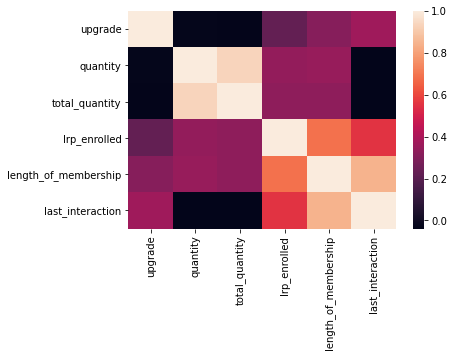

In [64]:
dfc = up_lrp.corr()
sns.heatmap(dfc)

In [65]:
dfc

,upgrade,quantity,total_quantity,lrp_enrolled,length_of_membership,last_interaction
upgrade,1.000000,-0.030179,-0.031217,0.228935,0.312475,0.372387
quantity,-0.030179,1.000000,0.937504,0.343676,0.352574,-0.038504
total_quantity,-0.031217,0.937504,1.000000,0.332361,0.333768,-0.037676
lrp_enrolled,0.228935,0.343676,0.332361,1.000000,0.691508,0.554178
length_of_membership,0.312475,0.352574,0.333768,0.691508,1.000000,0.849153
last_interaction,0.372387,-0.038504,-0.037676,0.554178,0.849153,1.000000


<AxesSubplot:xlabel='total_quantity', ylabel='length_of_membership'>

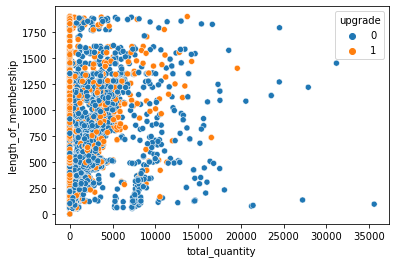

In [70]:
sns.scatterplot(data=up_lrp, y='length_of_membership', x='total_quantity', hue='upgrade')

<AxesSubplot:xlabel='total_quantity', ylabel='last_interaction'>

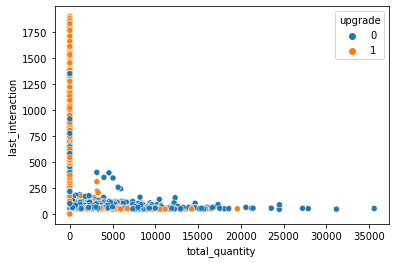

In [71]:
sns.scatterplot(data=up_lrp, y='last_interaction', x='total_quantity', hue='upgrade')

In [66]:
up_lrp.drop('date_observed', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [67]:
up_lrp

,line_id,upgrade,quantity,total_quantity,lrp_enrolled,length_of_membership,last_interaction
0,f0b99d3b-32f7-4464-8fa8-87f27c9810a8,1,0.0,0.0,1,1851.0,1851.0
1,a2ec0baf-1720-4b1b-bfa3-db00ac8fcb00,1,0.0,0.0,1,183.0,183.0
2,dd3a01a3-7baf-4605-9799-ce434328a20d,0,0.0,0.0,0,0.0,0.0
3,5cf5917c-f407-4cc7-9d6d-dafe8ec0eccc,0,0.0,0.0,0,0.0,0.0
4,6437fcbd-02c4-4c52-b5b2-f7e535ecec47,1,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...
55871,f89b108a-f453-4419-a4dc-5bf8e1cd1f1a,0,0.0,0.0,0,0.0,0.0
55872,b703f1d4-57ba-48b6-8adf-46d7aba6a406,0,3049.0,3049.0,1,630.0,67.0
55873,e3b2212c-906e-4a8f-8307-6b88fc64d7a0,0,0.0,0.0,1,101.0,101.0
55874,828df9bf-279c-47c3-96c2-92177a50b8fd,0,0.0,0.0,0,0.0,0.0


In [ ]:
up_lrp.to_csv(root_folder+"sample-notebook/up_lrp_to_merge.csv",header=True,index=None)